In [1]:
from keras.layers import Input, Dense
from keras.models import Model

input_all = Input(shape=(233,), name="input")

x = Dense(512,activation='relu')(input_all)

x = Dense(1024,activation= 'relu')(x)

x = Dense(512)(x)

out = Dense(4)(x)

model = Model(inputs=[input_all], outputs=out)
model.compile(optimizer='rmsprop', loss='mse')
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 233)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               119808    
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 2052      
Total params: 1,171,972
Trainable params: 1,171,972
Non-trainable params: 0
_________________________________________________________________


In [7]:
from emulator import CustomEmulator
import numpy as np

emul = CustomEmulator(500,10)
num_hands = 2
total_reward = 0
y = .99
e = 0.1

old_state = np.zeros((233))
targetQ = np.zeros((4))
replay_state = []
replay_Q = []
max_replay = 10000

bankroll_sb = [0]
bankroll_player1 = [0]
player1 = True

for i in range(num_hands):
    reward_sb = 0
    reward_bb = 0
    #Starts with dealer
    is_sb_turn = True
    
    sb_has_played = False
    bb_has_played = False
  
    emul.new_hand()
    #while hand is still at play
    while(emul.is_round_finished() == False):
           
        emul.make_features()
        if(is_sb_turn == True):
            #save old state to update it asap with new rew
            if(sb_has_played == True):
                old_state_sb = sb_features
                targetQ = allQ_sb
                
                ##tochange
            sb_features = np.concatenate([emul.players_cards[1], np.concatenate(
    emul.cards_feature), np.concatenate(emul.actions_feature),np.array([1])]).reshape((1,233))
            
            #run model to choose action
            allQ_sb = model.predict(sb_features)
            action_sb = np.argmax(allQ_sb)
            #print(allQ_sb)
            
            #randomly discover new line
            if(np.random.rand(1) < e):
                action_sb = np.random.randint(0,4)

            emul.play_action(action_sb)
                
            
            if(sb_has_played == True):
                targetQ[0,action_sb] = y*np.max(allQ_sb)
                #replay_state.append(old_state.reshape((233,)))
                #replay_Q.append(targetQ.reshape((4,)))

            sb_has_played = True
            is_sb_turn = False
            old_state_sb = sb_features
        else:
            if(bb_has_played == True):
                old_state_bb = bb_features
                targetQ = allQ_bb
                
            bb_features = np.concatenate([emul.players_cards[0], np.concatenate(
    emul.cards_feature), np.concatenate(emul.actions_feature),np.array([0])]).reshape((1,233))
            
            allQ_bb = model.predict(bb_features)
            action_bb = np.argmax(allQ_bb)
            
            if(np.random.rand(1) < e):
                action_bb = np.random.randint(0,4)
                
            emul.play_action(1)        
            
            if(bb_has_played == True):
                targetQ[0,action_bb] = y*np.max(allQ_bb)
                #replay_state.append(old_state.reshape((233,)))
                #replay_Q.append(targetQ.reshape((4,)))


            bb_has_played = True
            is_sb_turn = True
            old_state_bb = bb_features
                        
    r  = emul.get_sb_reward()
    total_reward +=r
    bankroll_sb.append(bankroll_sb[-1]+r)
    print(emul.events)
    if player1 == True:
        player1 = False
        bankroll_player1.append(bankroll_player1[-1]+r)
    else:
        player1 = True
        bankroll_player1.append(bankroll_player1[-1]-r)
    
    if(i%2000 == 0 and i > 10):
         #fit on replay
        model.fit(np.stack(replay_state),np.stack(replay_Q),verbose=1)
    
    if(i%2000== 0):
        print('round',i)
        print('Won(SB):',r,'  Total won (SB):',total_reward)
        print('Replay size:',len(replay_state))
        print(allQ_sb)
        print(emul.get_action_histories_text(hole_cards = True))

    allQ_sb[0,action_sb] = r

    replay_state.append(old_state_sb.reshape((233,)))
    replay_Q.append(allQ_sb.reshape((4,)))
    
    if(bb_has_played):   
        allQ_bb[0,action_bb] = -r
        replay_state.append(old_state_bb.reshape((233,)))
        replay_Q.append(allQ_bb.reshape((4,)))
    

    if(len(replay_state) > max_replay):
        replay_state = replay_state[50:]
        replay_Q = replay_Q[50:]

            

[{'type': 'event_new_street', 'street': 'flop', 'round_state': {'street': 'flop', 'pot': {'main': {'amount': 1000}, 'side': [{'amount': 0, 'eligibles': ['bb_player', 'sb_player']}, {'amount': 0, 'eligibles': ['bb_player', 'sb_player']}]}, 'community_card': ['S3', 'HJ', 'CT'], 'dealer_btn': 0, 'next_player': 'not_found', 'small_blind_pos': 1, 'big_blind_pos': 0, 'round_count': 1, 'small_blind_amount': 10, 'seats': [{'name': 'bb_player', 'uuid': 'bb_player', 'stack': 0, 'state': 'allin'}, {'name': 'sb_player', 'uuid': 'sb_player', 'stack': 0, 'state': 'allin'}], 'action_histories': {'preflop': [{'action': 'SMALLBLIND', 'amount': 10, 'add_amount': 10, 'uuid': 'sb_player'}, {'action': 'BIGBLIND', 'amount': 20, 'add_amount': 10, 'uuid': 'bb_player'}, {'action': 'RAISE', 'amount': 500, 'paid': 490, 'add_amount': 480, 'uuid': 'sb_player'}, {'action': 'CALL', 'amount': 500, 'paid': 480, 'uuid': 'bb_player'}], 'flop': []}}}, {'type': 'event_new_street', 'street': 'turn', 'round_state': {'street

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt


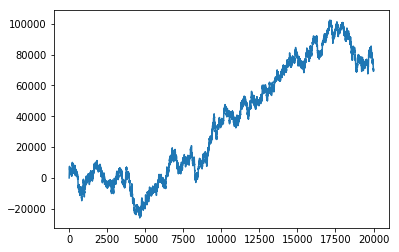

In [53]:
%matplotlib inline

plt.plot(bankroll_player1)


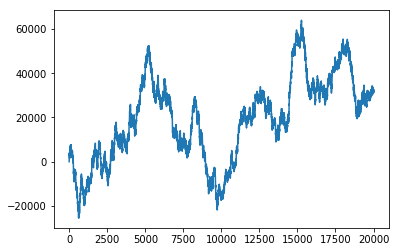

In [54]:
plt.plot(bankroll_sb)